In [2]:
%matplotlib inline
import seaborn as sns
import os, sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import scipy.signal as signal
from scipy import optimize
import scipy.optimize as opt
import pandas as pd
from scipy import fftpack
sys.path.append('/home/yuhanw/repos/pysmurf/python')
import pysmurf.client
S = pysmurf.client.SmurfControl(offline=True)
from scipy.signal import welch, hilbert

[ 2021-04-16 01:16:48 ]  Offline mode


In [3]:
def ctime_from_dat(iv_file):
    file=iv_file.split('/')[-1]
    ctime=file.split('.')[0]
    return ctime


def noise_model(freq, wl, n, f_knee):
            """
            Crude model for noise modeling.
            Args
            ----
            wl : float
                White-noise level.
            n : float
                Exponent of 1/f^n component.
            f_knee : float
                Frequency at which white noise = 1/f^n component
            """
            A = wl*(f_knee**n)

            # The downsample filter is at the flux ramp frequency
            w, h = signal.freqz(filter_b, filter_a, worN=freq,
                fs=flux_ramp_freq)
            tf = np.absolute(h) # filter transfer function
#             print(A/(freq**n) + wl)
            return (A/(freq**n) + wl)*tf

In [6]:
filename_wave = '/Users/yuhanwang/Desktop/SO_inlab/cross_talk/1617582197.dat'
freq_file_wave = '/Users/yuhanwang/Desktop/SO_inlab/cross_talk/1617582197_freq.txt'

In [7]:
freq_list_new = []
with open(freq_file_wave) as file:
    for lines in file: 
        freq_list_new.append(float(lines))

In [8]:
print(len(freq_list_new))

426


In [9]:
# this should be the frequency of you sine wave going in

target_freq = 6.39

# setting might be different to your system

timestamp, phase, mask, tes_bias = S.read_stream_data(filename_wave,
            return_tes_bias=True)
bands, channels = np.where(mask!=-1)
S._pA_per_phi0 = 9000000.0
phase *= S._pA_per_phi0/(2.*np.pi)
flux_ramp_freq = S.get_flux_ramp_freq() * 1.0E3
filter_b = S.get_filter_b()
filter_a = S.get_filter_a()
downsample_factor = S.get_downsample_factor()
# flux ramp rate returns in kHz
fs = flux_ramp_freq/downsample_factor
downsample_freq, downsample_transfer = signal.freqz(filter_b,filter_a, worN=np.arange(.01, fs/2, .01), fs=flux_ramp_freq)
downsample_transfer = np.abs(downsample_transfer)
print()
nperseg=2**16
detrend='constant'
phase = phase - np.mean(phase,axis = 1).reshape((np.shape(phase)[0],1))

[ 2021-04-16 01:22:46 ]  Reading /Users/yuhanwang/Desktop/SO_inlab/cross_talk/1617582197.dat
Processing data records from /Users/yuhanwang/Desktop/SO_inlab/cross_talk/1617582197.dat
[ 2021-04-16 01:22:46 ]  2048 elements loaded
[ 2021-04-16 01:22:47 ]  4096 elements loaded
[ 2021-04-16 01:22:48 ]  6144 elements loaded
[ 2021-04-16 01:22:49 ]  8192 elements loaded
[ 2021-04-16 01:22:50 ]  10240 elements loaded
[ 2021-04-16 01:22:51 ]  12288 elements loaded
[ 2021-04-16 01:22:52 ]  14336 elements loaded
[ 2021-04-16 01:22:53 ]  16384 elements loaded
[ 2021-04-16 01:22:55 ]  18432 elements loaded
[ 2021-04-16 01:22:56 ]  20480 elements loaded
[ 2021-04-16 01:22:57 ]  22528 elements loaded
[ 2021-04-16 01:22:59 ]  24576 elements loaded
[ 2021-04-16 01:23:00 ]  26624 elements loaded
[ 2021-04-16 01:23:01 ]  28672 elements loaded
[ 2021-04-16 01:23:03 ]  30720 elements loaded
[ 2021-04-16 01:23:04 ]  32768 elements loaded
[ 2021-04-16 01:23:05 ]  34816 elements loaded
[ 2021-04-16 01:23:07 ]

In [44]:

for c, (b, ch) in enumerate(zip(bands, channels)):
    ch_idx = mask[b, ch]
    sampleNums = np.arange(len(phase[ch_idx]))
    t_array = sampleNums / fs
    victim_data = phase[ch_idx]
    f, Pxx = signal.welch(phase[ch_idx], nperseg=nperseg,
        fs=fs, detrend=detrend)
    Pxx = np.sqrt(Pxx)
    try:
        # popt, pcov, f_fit, Pxx_fit = S.analyze_psd(f, Pxx,
        #                 fs=fs, flux_ramp_freq=flux_ramp_freq)
        # wl, n, f_knee = popt
    
        
        freq_mask = ((np.abs(f) < target_freq + 0.2) & (np.abs(f) > target_freq - 0.2))
        range_peaks, _ = find_peaks(Pxx[freq_mask], height=500)
        f_range = f[freq_mask]
        Pxx_range = Pxx[freq_mask]
        peak_freq = np.float(f_range[Pxx_range.argmax()])
        peak_height = np.float(Pxx_range[Pxx_range.argmax()])
        # expect_target_noise = np.float(noise_model([peak_freq],wl,n,f_knee))
        target_peak_mask = (np.abs(f) == peak_freq)
        #efforts of sorting out bad tracking and perpentrator chanels
        if peak_height > 10000:
            print(b,ch,c)
    except:
        continue

5 29 15
5 57 28
5 67 32
5 163 74
5 185 84
5 188 86
5 208 99
5 300 132
5 339 143
5 355 153
5 365 156
5 419 179
5 486 204
5 493 206
6 55 234
6 77 243
6 484 413


2.6


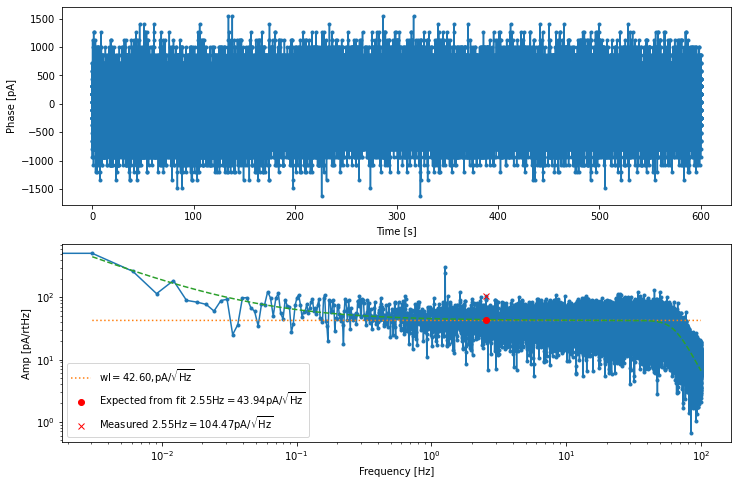

In [60]:
for c, (b, ch) in enumerate(zip(bands, channels)):
    if ch < 0:
        continue
    #plotting individual channel out to check
    if ch == int(191) and b == int(6):
        ch_idx = mask[b, ch]
        sampleNums = np.arange(len(phase[ch_idx]))
        t_array = sampleNums / fs
        f, Pxx = signal.welch(phase[ch_idx], nperseg=nperseg,
            fs=fs, detrend=detrend)
        Pxx = np.sqrt(Pxx)
        try:
            popt, pcov, f_fit, Pxx_fit = S.analyze_psd(f, Pxx,
                            fs=fs, flux_ramp_freq=flux_ramp_freq)
            wl, n, f_knee = popt
        except:
            continue
        target_freq = 2.6
        freq_mask = ((np.abs(f) < target_freq + 0.1) & (np.abs(f) > target_freq - 0.1))
        range_peaks, _ = find_peaks(Pxx[freq_mask], height=500)
        f_range = f[freq_mask]
        Pxx_range = Pxx[freq_mask]
        peak_freq = np.float(f_range[Pxx_range.argmax()])
        peak_height = np.float(Pxx_range[Pxx_range.argmax()])
        
        target_peak_mask = (np.abs(f) == peak_freq)
#         target_noise_level_list.append(peak_height)
#         target_noise_freq_list.append(peak_freq)
        
        plt.figure(figsize=(12,8))
        plt.subplot(2, 1, 1)
        plt.plot(t_array,phase[ch_idx] - np.mean(phase[ch_idx]),'.-')
        plt.xlabel('Time [s]')
        plt.ylabel('Phase [pA]')
        plt.subplot(2, 1, 2)
        plt.loglog(f,Pxx,'.-')
        try:
            expect_target_noise = np.float(noise_model([peak_freq],wl,n,f_knee))
            plt.plot(f_fit,wl + np.zeros(len(f_fit)), linestyle=':',label=r'$\mathrm{wl} = $'+ f'{wl:0.2f},' +
                                    r'$\mathrm{pA}/\sqrt{\mathrm{Hz}}$')
            plt.plot(f_fit, Pxx_fit, linestyle='--')
            plt.plot(peak_freq,expect_target_noise,'o',label = r'$\mathrm{Expected\ from\ fit\ }  $'+ f'{peak_freq:0.2f}'+r'$\mathrm{Hz} = $'+ f'{expect_target_noise:0.2f}' +
                                r'$\mathrm{pA}/\sqrt{\mathrm{Hz}}$',color = 'r')
        except:
            continue
        plt.plot(f[target_peak_mask],Pxx[target_peak_mask],'x',label = r'$\mathrm{Measured\ } $'+ f'{peak_freq:0.2f}'+r'$\mathrm{Hz} = $'+ f'{peak_height:0.2f}' +
                                r'$\mathrm{pA}/\sqrt{\mathrm{Hz}}$',color = 'r')
        
        plt.legend()
        plt.xlabel('Frequency [Hz]')
        plt.ylabel('Amp [pA/rtHz]')
#         plt.savefig('{}/{}_band_{}_chan_{}_{}Hz.png'.format(output,ctime,b,ch,target_freq),bbox_inches='tight', transparent=False,facecolor=(1,1,1,1))
        print(target_freq)

In [32]:
for c, (b, ch) in enumerate(zip(bands, channels)):
    # the perpentrator band and channel
    if b == 5 and ch == 57:
        ch_idx = mask[b, ch]
        sampleNums = np.arange(len(phase[ch_idx]))
        t_array = sampleNums / fs
        perp_data = phase[ch_idx]
        quad_perp_data = np.imag(hilbert(perp_data))
        perp_norm = np.average(perp_data[500:-500]*perp_data[500:-500])
        quad_perp_norm = np.average(quad_perp_data[500:-500]*quad_perp_data[500:-500])
        
inphase_list = []
outphase_list = []
target_freq_list_2 = []
for c, (b, ch) in enumerate(zip(bands, channels)):
    if not ((b == 5 and ch == 188) or (b == 5 and ch == 208) or (b == 5 and ch == 339) or (b == 6 and ch == 55) or (b == 6 and ch == 77) or (b == 6 and ch == 484)):
        ch_idx = mask[b, ch]
        sampleNums = np.arange(len(phase[ch_idx]))
        t_array = sampleNums / fs
        victim_data = phase[ch_idx]
        inphase_lockin  = np.average(victim_data[500:-500]*perp_data[500:-500])/perp_norm
        outphase_lockin = np.average(victim_data[500:-500]*quad_perp_data[500:-500])/quad_perp_norm
        inphase_list.append(abs(inphase_lockin))
        outphase_list.append(abs(outphase_lockin))
        
        if freq_list_new[ch_idx] > 6000:
            target_freq_list_2.append(freq_list_new[ch_idx]-2000)
        else:
            target_freq_list_2.append(freq_list_new[ch_idx])
            
        ch_idx = mask[b, ch]
        sampleNums = np.arange(len(phase[ch_idx]))
        t_array = sampleNums / fs
        victim_data = phase[ch_idx]
        f, Pxx = signal.welch(phase[ch_idx], nperseg=nperseg,
            fs=fs, detrend=detrend)
        Pxx = np.sqrt(Pxx)
        try:
        # popt, pcov, f_fit, Pxx_fit = S.analyze_psd(f, Pxx,
        #                 fs=fs, flux_ramp_freq=flux_ramp_freq)
        # wl, n, f_knee = popt
    
        
            freq_mask = ((np.abs(f) < target_freq + 0.2) & (np.abs(f) > target_freq - 0.2))
            range_peaks, _ = find_peaks(Pxx[freq_mask], height=500)
            f_range = f[freq_mask]
            Pxx_range = Pxx[freq_mask]
            peak_freq = np.float(f_range[Pxx_range.argmax()])
            peak_height = np.float(Pxx_range[Pxx_range.argmax()])
            # expect_target_noise = np.float(noise_model([peak_freq],wl,n,f_knee))
            target_peak_mask = (np.abs(f) == peak_freq)
            if peak_height > 100000:
                print(b,ch,c)
        except:
            continue


5 57 28
5 300 132
5 419 179
5 493 206


In [33]:
print(freq_list_new[28])

6509.922


Text(0, 0.5, 'crosstalk fraction')

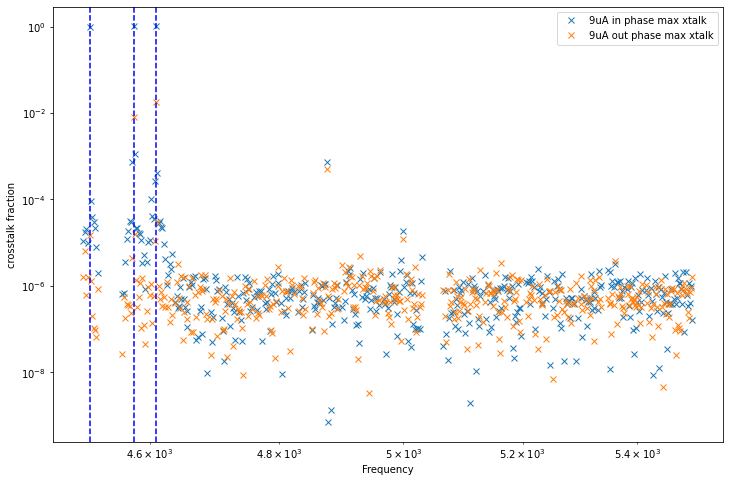

In [34]:
plt.figure(figsize=(12,8))

plt.plot(target_freq_list_2,np.array(inphase_list),'x',label = 'in phase xtalk')
plt.plot(target_freq_list_2,np.array(outphase_list),'x',label = 'out phase xtalk')


#dash lines are the perpentrators 

plt.axvline(freq_list_new[28]-2000, color = 'b', linestyle='--')
plt.axvline(freq_list_new[179]-2000, color = 'b', linestyle='--')
plt.axvline(freq_list_new[206]-2000, color = 'b', linestyle='--')


plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Frequency')
plt.ylabel('crosstalk fraction')

(4490.0, 4710.0)

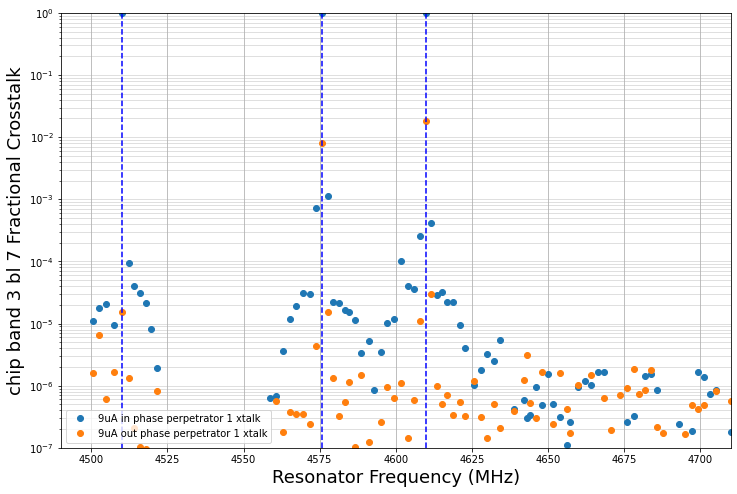

In [42]:
fig5 = plt.figure(figsize=(12,8))
ax51 = fig5.add_subplot(111)
# ax51.plot(target_freq_list_2,np.array(inphase_list_173),'o',label = '0.9uA in phase perpetrator 1 xtalk ')
# ax51.plot(target_freq_list_2,np.array(outphase_list_173),'o',label = '0.9uA out phase perpetrator 1 xtalk')
# ax51.plot(target_freq_list_2,np.array(inphase_list_173_2),'o',label = '4.5uA in phase perpetrator 1 xtalk ')
# ax51.plot(target_freq_list_2,np.array(outphase_list_173_2),'o',label = '4.5uA out phase perpetrator 1 xtalk')
ax51.plot(target_freq_list_2,np.array(inphase_list),'o',label = '9uA in phase perpetrator 1 xtalk ')
ax51.plot(target_freq_list_2,np.array(outphase_list),'o',label = '9uA out phase perpetrator 1 xtalk')
# ax51.plot(target_freq_list_2,np.array(inphase_list_153),'o',label = '0.9uA in phase perpetrator 2 xtalk')
# ax51.plot(target_freq_list_2,np.array(outphase_list_153),'o',label = '0.9uA out phase perpetrator 2 xtalk')
# ax51.plot(target_freq_list_2,np.array(inphase_list_67),'o',label = '0.9uA in phase perpetrator 3 xtalk')
# ax51.plot(target_freq_list_2,np.array(outphase_list_67),'o',label = '0.9uA out phase perpetrator 3 xtalk')
# ax51.axvline(target_freq_list_2[79], color = 'b', linestyle='--')
# ax51.axvline(target_freq_list_2[69], color = 'b', linestyle='--')
# ax51.axvline(target_freq_list_2[32], color = 'b', linestyle='--')
ax51.axvline(freq_list_new[28]-2000, color = 'b', linestyle='--')
ax51.axvline(freq_list_new[179]-2000, color = 'b', linestyle='--')
ax51.axvline(freq_list_new[206]-2000, color = 'b', linestyle='--')
ax51.grid(True)
ax51.grid(True, which = 'both', axis = 'y', alpha = 0.5)
ax51.set_xlabel('Resonator Frequency (MHz)', fontsize = 18)
ax51.set_ylabel('chip band 3 bl 7 Fractional Crosstalk', fontsize = 18)
ax51.set_yscale('log')
ax51.legend(loc = 'lower left')
ax51.set_ylim([1e-7,1])
ax51.set_xlim([4490,4710])

(4400.0, 5500.0)

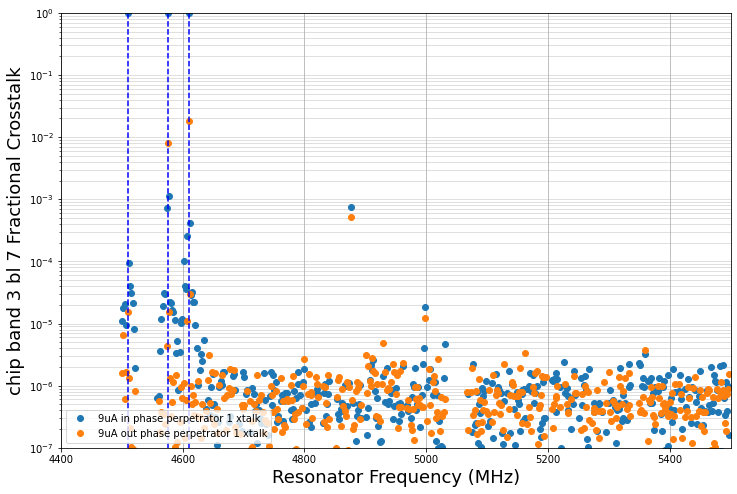

In [41]:
fig5 = plt.figure(figsize=(12,8))
ax51 = fig5.add_subplot(111)
# ax51.plot(target_freq_list_2,np.array(inphase_list_173),'o',label = '0.9uA in phase perpetrator 1 xtalk ')
# ax51.plot(target_freq_list_2,np.array(outphase_list_173),'o',label = '0.9uA out phase perpetrator 1 xtalk')
# ax51.plot(target_freq_list_2,np.array(inphase_list_173_2),'o',label = '4.5uA in phase perpetrator 1 xtalk ')
# ax51.plot(target_freq_list_2,np.array(outphase_list_173_2),'o',label = '4.5uA out phase perpetrator 1 xtalk')
ax51.plot(target_freq_list_2,np.array(inphase_list),'o',label = '9uA in phase perpetrator 1 xtalk ')
ax51.plot(target_freq_list_2,np.array(outphase_list),'o',label = '9uA out phase perpetrator 1 xtalk')
# ax51.plot(target_freq_list_2,np.array(inphase_list_153),'o',label = '0.9uA in phase perpetrator 2 xtalk')
# ax51.plot(target_freq_list_2,np.array(outphase_list_153),'o',label = '0.9uA out phase perpetrator 2 xtalk')
# ax51.plot(target_freq_list_2,np.array(inphase_list_67),'o',label = '0.9uA in phase perpetrator 3 xtalk')
# ax51.plot(target_freq_list_2,np.array(outphase_list_67),'o',label = '0.9uA out phase perpetrator 3 xtalk')
# ax51.axvline(target_freq_list_2[79], color = 'b', linestyle='--')
# ax51.axvline(target_freq_list_2[69], color = 'b', linestyle='--')
# ax51.axvline(target_freq_list_2[32], color = 'b', linestyle='--')
ax51.axvline(freq_list_new[28]-2000, color = 'b', linestyle='--')
ax51.axvline(freq_list_new[179]-2000, color = 'b', linestyle='--')
ax51.axvline(freq_list_new[206]-2000, color = 'b', linestyle='--')
ax51.grid(True)
ax51.grid(True, which = 'both', axis = 'y', alpha = 0.5)
ax51.set_xlabel('Resonator Frequency (MHz)', fontsize = 18)
ax51.set_ylabel('chip band 3 bl 7 Fractional Crosstalk', fontsize = 18)
ax51.set_yscale('log')
ax51.legend(loc = 'lower left')
ax51.set_ylim([1e-7,1])
ax51.set_xlim([4400,5500])